In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
import warnings
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv('../data/StoreDemand.csv')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [40]:
df.shape

(913000, 4)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [42]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


## Feature Engineering

In [43]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"] = parts[0].astype('int')
df["month"] = parts[1].astype('int')
df["day"] = parts[2].astype('int')
df.head

<bound method NDFrame.head of               date  store  item  sales  year  month  day
0       2013-01-01      1     1     13  2013      1    1
1       2013-01-02      1     1     11  2013      1    2
2       2013-01-03      1     1     14  2013      1    3
3       2013-01-04      1     1     13  2013      1    4
4       2013-01-05      1     1     10  2013      1    5
...            ...    ...   ...    ...   ...    ...  ...
912995  2017-12-27     10    50     63  2017     12   27
912996  2017-12-28     10    50     59  2017     12   28
912997  2017-12-29     10    50     74  2017     12   29
912998  2017-12-30     10    50     62  2017     12   30
912999  2017-12-31     10    50     82  2017     12   31

[913000 rows x 7 columns]>

In [44]:
print(parts)

           0   1   2
0       2013  01  01
1       2013  01  02
2       2013  01  03
3       2013  01  04
4       2013  01  05
...      ...  ..  ..
912995  2017  12  27
912996  2017  12  28
912997  2017  12  29
912998  2017  12  30
912999  2017  12  31

[913000 rows x 3 columns]


In [45]:
from datetime import datetime
import calendar

def weekend_or_weekday(year, month, day):
    d = datetime(year, month, day)
    if d.weekday() >= 5:
        return 1
    else: 
        return 0

df['weekend'] = df.apply(lambda x: weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [46]:
from datetime import date
import holidays

def is_holiday(x):

    india_holidays = holidays.country_holidays('IN')

    if india_holidays.get(x):
        return 1
    else:
        return 0
df['holidays'] = df['date'].apply(is_holiday)
df.head()

,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


### Cyclical Features

In [47]:
df['m1'] = np.sin(df['month']) * (2 * np.pi / 12)
df['m2'] = np.cos(df['month']) * (2 * np.pi / 12)
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,0.440593,0.282902
1,2013-01-02,1,1,11,2013,1,2,0,0,0.440593,0.282902
2,2013-01-03,1,1,14,2013,1,3,0,0,0.440593,0.282902
3,2013-01-04,1,1,13,2013,1,4,0,0,0.440593,0.282902
4,2013-01-05,1,1,10,2013,1,5,1,0,0.440593,0.282902


In [48]:
def which_day_of_weekday(year, month, day):
    d = datetime(int(year), int(month), int(day))
    # if d.weekday() <= 4: # Mon-Fri(0-4)
    return d.weekday() + 1 # return 1-5

df['weekday'] = df.apply(lambda x: which_day_of_weekday(x['year'], x['month'], x['day']), axis=1).astype('Int64')
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,0.440593,0.282902,2
1,2013-01-02,1,1,11,2013,1,2,0,0,0.440593,0.282902,3
2,2013-01-03,1,1,14,2013,1,3,0,0,0.440593,0.282902,4
3,2013-01-04,1,1,13,2013,1,4,0,0,0.440593,0.282902,5
4,2013-01-05,1,1,10,2013,1,5,1,0,0.440593,0.282902,6


In [49]:
# def which_day_type(year, month, day):
#     d = datetime(year, month, day)
#     if d.weekday() <= 4:  # Mon-Fri (0-4)
#         return d.weekday() + 1, None  # 返回 weekday 值，weekend 为 None
#     else:
#         return None, 1  # weekend 值为1，weekday 为 None


# df['weekday'], df['weekend'] = zip(*df.apply(lambda x: which_day_type(x['year'], x['month'], x['day']), axis=1))

# df.head()

In [50]:
df.drop('date', axis=1, inplace=True)

In [51]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

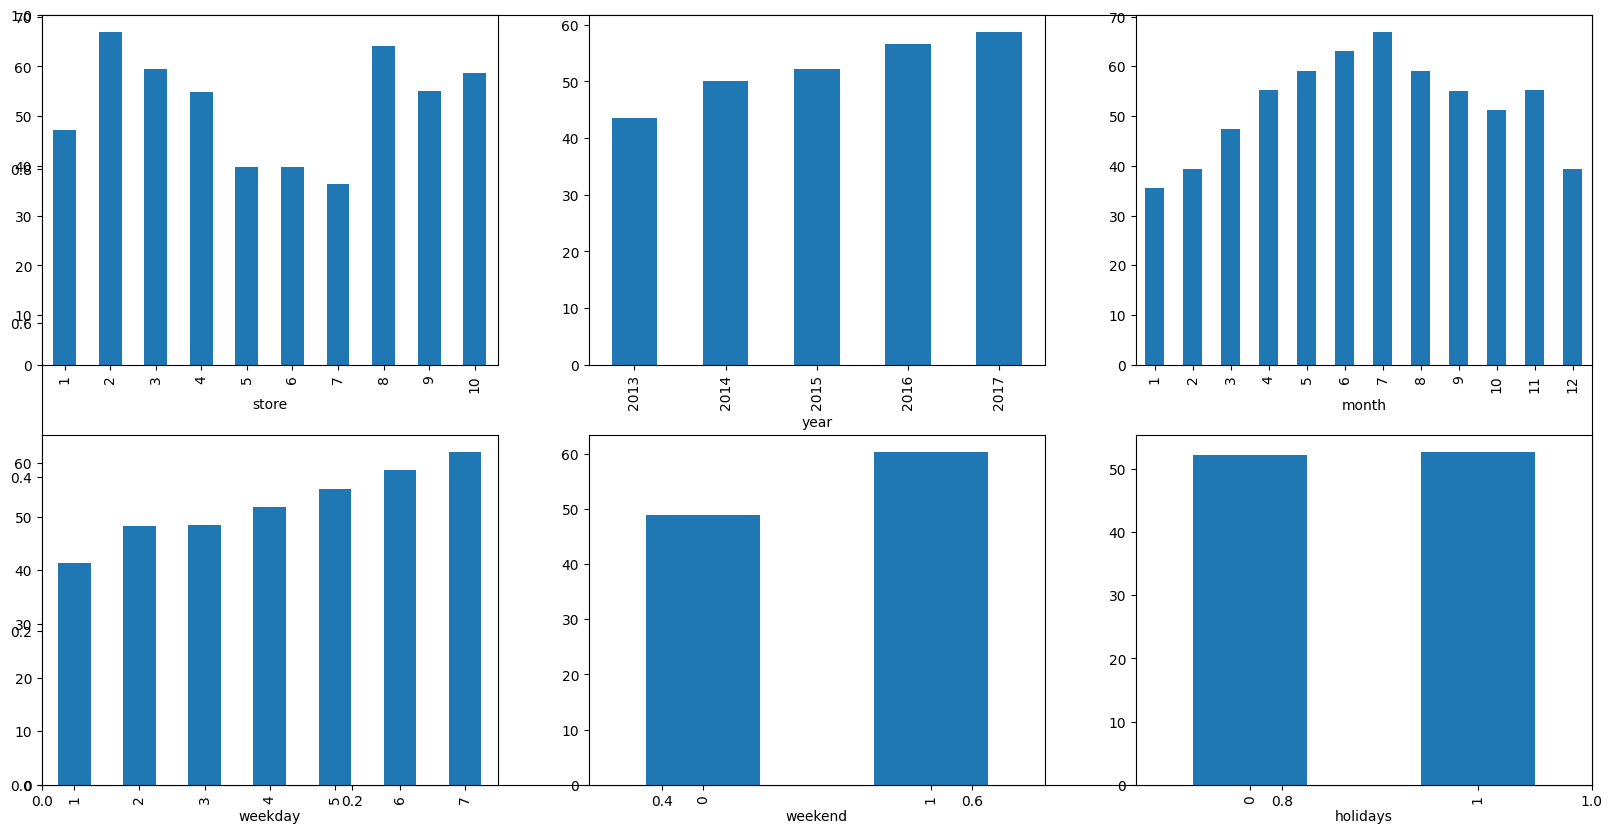

In [52]:
features = ['store', 'year', 'month',\
            'weekday', 'weekend', 'holidays']
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()

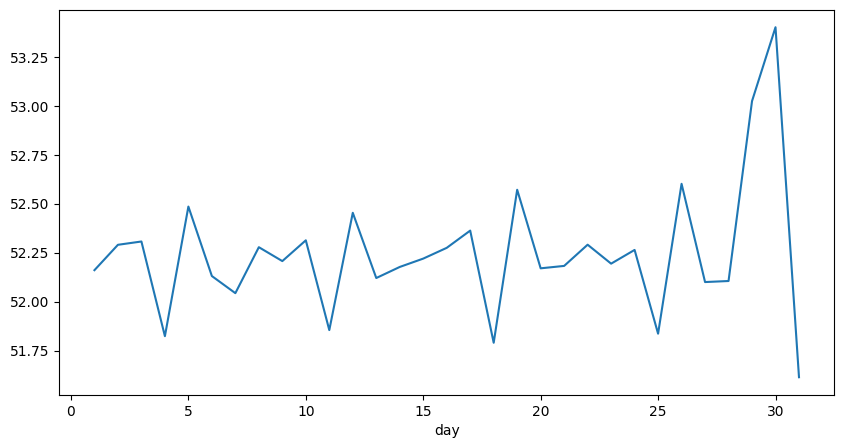

In [53]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

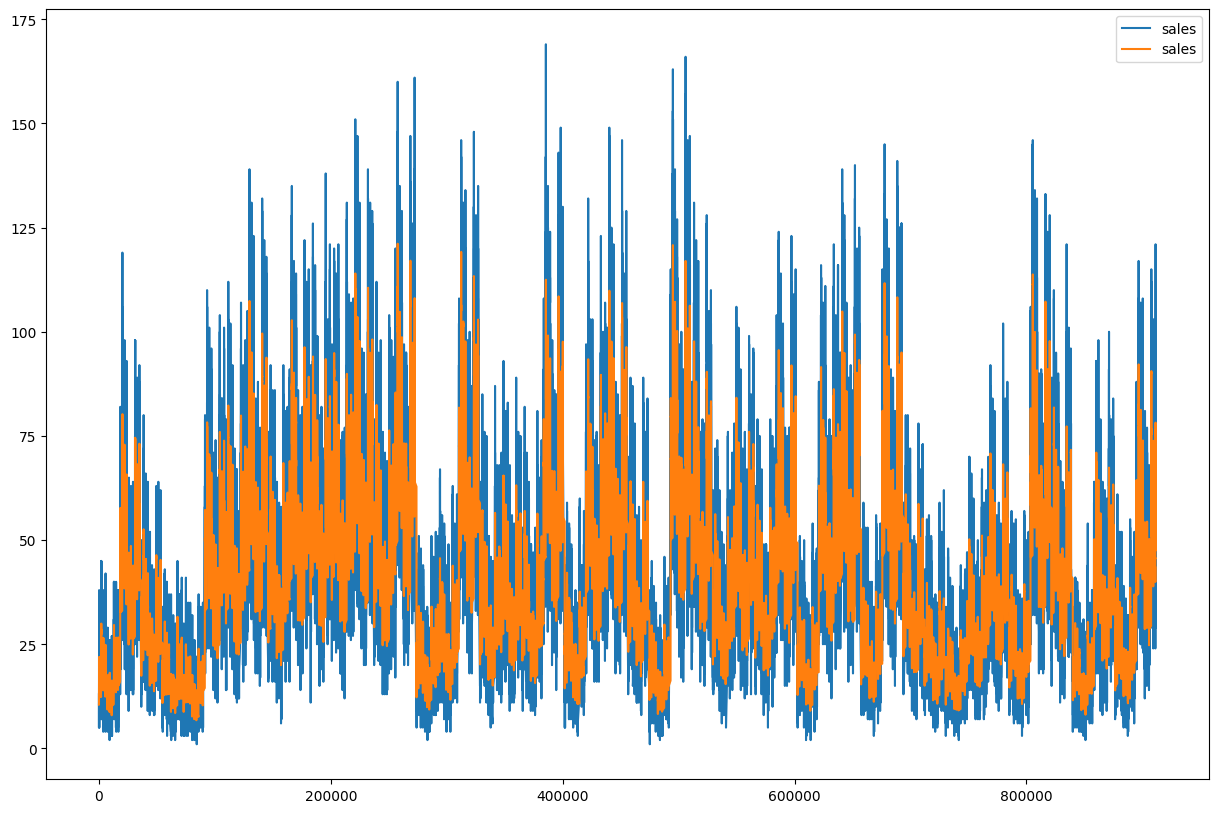

In [54]:
plt.figure(figsize=(15,10))
window_size = 30
data = df[df['year'] == 2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

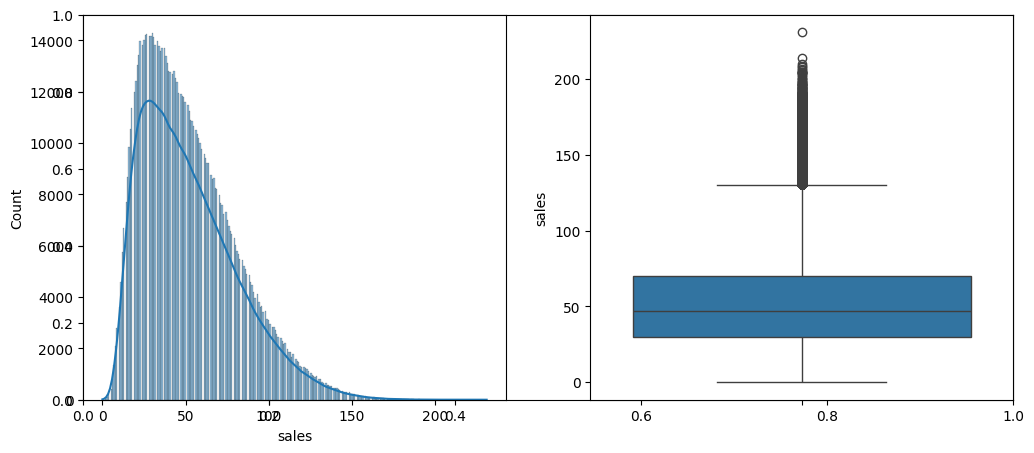

In [55]:
plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)
sb.histplot(df['sales'], kde=True)

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

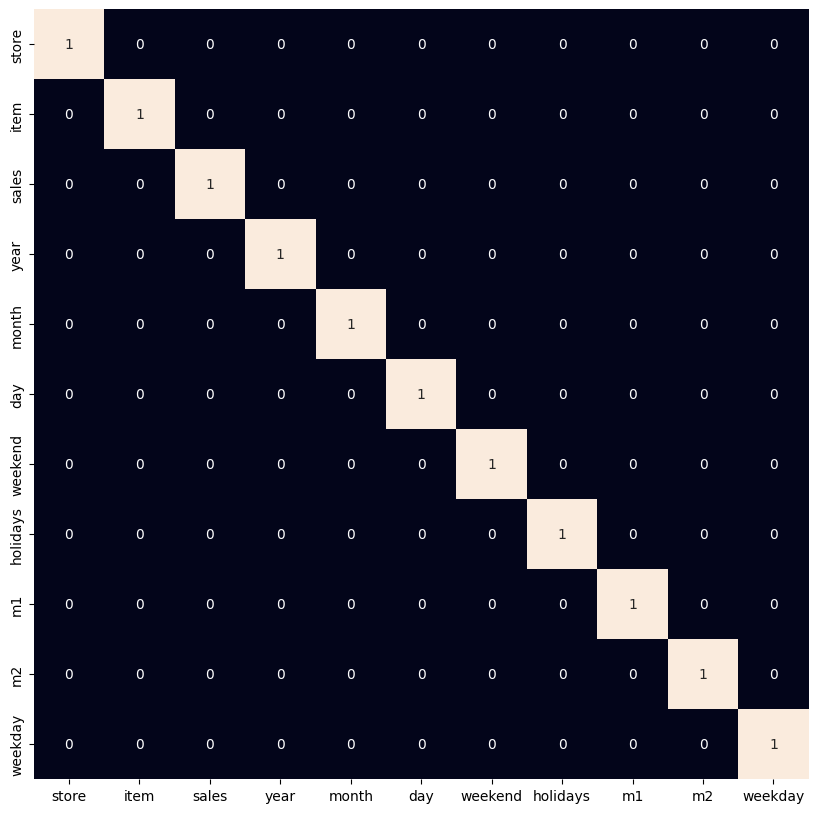

In [56]:
plt.figure(figsize=(10,10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

In [57]:
df_new = df[df['sales'] < 140]

In [59]:
features = df_new.drop(['sales', 'year'], axis=1)
target = df_new['sales'].values
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size=0.05, random_state=22)
X_train.shape, X_val.shape

((861170, 9), (45325, 9))